In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.get_cluster import C_rsmso,cluster_os
from TO_sim.To_Draw import Draw_avg_vel_r

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap

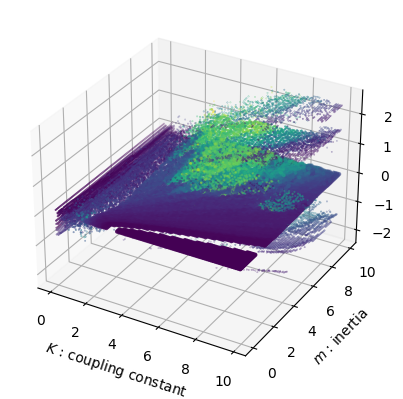

In [5]:
df = pd.read_excel('test 230620.xlsm',index_col=[0,1])
df = pd.read_excel('N = 500 seed = 10 test 230621.xlsm',index_col=[0,1])
# df_Km = df.reset_index(['K','m'])
KK = df.index.to_frame().K.unstack().to_numpy().T
MM = df.index.to_frame().m.unstack().to_numpy().T
# origin = 'lower'
# CS = plt.contourf(KK,MM,df['rMM'].unstack().T, 20, cmap=plt.cm.viridis, origin=origin)
# CS2 = plt.contour(CS, levels=CS.levels[::], colors='k',linewidths = 0.5, origin=origin)
# plt.colorbar()
Ks = df.reset_index().K
ms = df.reset_index().m
Ss_c0 = df.reset_index()['S c0'].to_numpy()
Ss_c1 = df.reset_index()['S c1'].to_numpy()
Ss_c2 = df.reset_index()['S c2'].to_numpy()
Ss_c3 = df.reset_index()['S c3'].to_numpy()
Ss_c4 = df.reset_index()['S c4'].to_numpy()
Ss_c5 = df.reset_index()['S c5'].to_numpy()

So_c0 = df.reset_index()['S c0 omega'].to_numpy()
So_c1 = df.reset_index()['S c1 omega'].to_numpy()
So_c2 = df.reset_index()['S c2 omega'].to_numpy()
So_c3 = df.reset_index()['S c3 omega'].to_numpy()
So_c4 = df.reset_index()['S c4 omega'].to_numpy()
So_c5 = df.reset_index()['S c5 omega'].to_numpy()

rMM = df.reset_index()['rMM']


# plt.subplot(projection='3d')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Ks,ms,So_c0,c=rMM,s=Ss_c0*0.01)
ax.scatter(Ks,ms,So_c1,c=rMM,s=Ss_c1*0.01)
ax.scatter(Ks,ms,So_c2,c=rMM,s=Ss_c2*0.01)
ax.scatter(Ks,ms,So_c3,c=rMM,s=Ss_c3*0.01)
ax.scatter(Ks,ms,So_c4,c=rMM,s=Ss_c4*0.01)
ax.scatter(Ks,ms,So_c5,c=rMM,s=Ss_c5*0.01)

ax.set_xlabel('$K$ : coupling constant')
ax.set_ylabel('$m$ : inertia')
ax.set_zlabel('cluster phase velocity')
# plt.zlim(-0.)
# plt.scatter(Ks,ms,Ss,Ss)
plt.show()


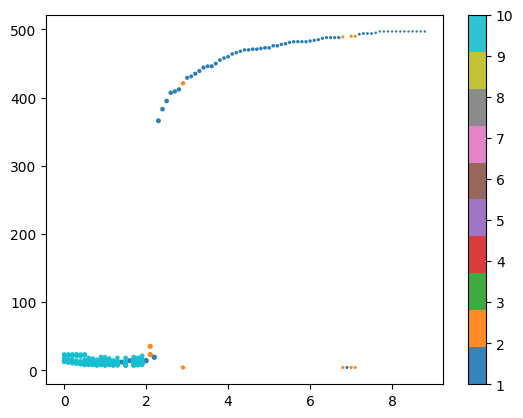

In [8]:
m_idx = 20
ms = df.reset_index().m.unique()
re_df = df.reset_index()

df_m = re_df[re_df.m == ms[m_idx]]
Ks = df_m.K.to_numpy()
rs = df_m.r.to_numpy()
rstd = df_m.rstd.to_numpy()
rMM= df_m.rMM.to_numpy()
cluster_s = df_m.iloc[:,5:15]
cluster_o = df_m.iloc[:,15:25]

len_cluster = (~cluster_o.isna()).sum(axis=1).to_numpy()
plt.scatter(np.ones((10,100))*Ks,cluster_s.to_numpy().T,alpha=0.9,
            c=np.ones((10,100))*(len_cluster),s=50*np.ones((10,100))*rMM,cmap='tab10')
plt.colorbar()

In [11]:
len_cluster = (~cluster_o.isna()).sum(axis=1)
df_m.K.loc[df_m.K>2][len_cluster ==0]

8920    8.9
9020    9.0
9120    9.1
9220    9.2
9320    9.3
9420    9.4
9520    9.5
9620    9.6
9720    9.7
9820    9.8
9920    9.9
Name: K, dtype: float64

## RK4 수정 ensemble version으로

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.get_cluster import C_rsmso,cluster_os
from TO_sim.To_Draw import Draw_avg_vel_r

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
import parmap

In [5]:
seed =10
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
omega = np.sort(omega) 
K = 5
m = 5
t_end = 500
dt =0.1
t = np.arange(0,t_end,dt)
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_init,p_dtheta= 0*omega,p_omega=omega,result_time = 0)#int((t_end)-(600))*int(1/dt))
if m == 0:
        dtheta = np.c_[dtheta[0],dtheta.T].T

In [6]:
N_set = 10
theta_sets = (np.ones((N_set,1))*np.r_[theta_init,np.zeros_like(theta_init)])
omega_sets = (np.ones((N_set,1))*omega)
K_set = np.arange(10).reshape(-1,1)
m_set = np.arange(1,11).reshape(-1,1)

def get_order_parameter_sets(theta,N,N_set):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta),axis=1)
    r = np.abs(rpsi).reshape((-1,1))
    psi = np.angle(rpsi).reshape((-1,1))
    return r,psi

def Kuramoto_2nd_mf_sets(theta_sets,t,omega_sets,N,m,K_set,N_set):
    theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
    r,psi = get_order_parameter_sets(theta,N,N_set)
    ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
    return np.c_[dtheta,ddtheta]

def Kuramoto_2nd_mf_sets_r(theta_sets,t,omega_sets,N,m,K_set,N_set):
    theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
    r,psi = get_order_parameter_sets(theta,N,N_set)
    ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
    return np.c_[dtheta,ddtheta],r

def Kuramoto_1st_mf(theta_sets,t,omega,N,m,K):
    # print("Case m = 0")
    theta= theta_sets[:,:N]
    r,psi = get_order_parameter_sets(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta)
    return np.c_[dtheta,np.zeros(N)]


def Kuramoto_1st_mf_r(theta_sets,t,omega,N,m,K):
    # print("Case m = 0")
    theta= theta_sets[:,:N]
    r,psi = get_order_parameter_sets(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta)
    return np.c_[dtheta,np.zeros(N)],r


In [7]:
N_set = 10
theta_sets = (np.ones((N_set,1))*np.r_[theta_init,np.zeros_like(theta_init)])
omega_sets = (np.ones((N_set,1))*omega)
K_set = np.arange(10).reshape(-1,1)
m_set = np.arange(1,11).reshape(-1,1)
def Kuramoto_2nd_mf_sets(theta_sets,t,omega_sets,N,m,K_set,N_set):
    theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
    r,psi = get_order_parameter_sets(theta,N,N_set)
    ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
    return np.c_[dtheta,ddtheta]


In [37]:
theta_,dtheta_ = theta_sets[:,:N],theta_sets[:,N:2*N]
r,psi = get_order_parameter_sets(theta_,N,N_set)
ddtheta_ = (1/m)*(-dtheta_ + omega_sets + K_set*r*np.sin(psi - theta_))


array([[-0.64088027, -0.59591935, -0.4791144 , ...,  0.49306502,
         0.49353021,  0.53598206],
       [-0.64214578, -0.59971821, -0.47704732, ...,  0.4892128 ,
         0.49740903,  0.53997483],
       [-0.64341128, -0.60351707, -0.47498024, ...,  0.48536058,
         0.50128784,  0.54396759],
       ...,
       [-0.64973882, -0.62251135, -0.46464483, ...,  0.46609948,
         0.52068191,  0.56393141],
       [-0.65100433, -0.6263102 , -0.46257774, ...,  0.46224726,
         0.52456073,  0.56792418],
       [-0.65226983, -0.63010906, -0.46051066, ...,  0.45839504,
         0.52843954,  0.57191694]])

In [25]:
n = 5
y = np.zeros((n, *A.shape))
y[0] = A
f = Kuramoto_2nd_mf_sets
args = (omega_sets,N,m,K_set,N_set)
for i in range(n - 1):
    h = t[i + 1] - t[i]
    k1 = f(y[i], t[i], *args)
    k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
    k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
    k4 = f(y[i] + k3 * h, t[i] + h, *args)
    y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

In [60]:
y[4]

array([[ 1.70475788, -3.01120431,  0.83973663, ...,  0.19722601,
         0.19741208,  0.21439282],
       [ 1.70475788, -3.01120431,  0.83973663, ...,  0.19568512,
         0.19896361,  0.21598993],
       [ 1.70475788, -3.01120431,  0.83973663, ...,  0.19414423,
         0.20051514,  0.21758704],
       ...,
       [ 1.70475788, -3.01120431,  0.83973663, ...,  0.18643979,
         0.20827277,  0.22557256],
       [ 1.70475788, -3.01120431,  0.83973663, ...,  0.18489891,
         0.20982429,  0.22716967],
       [ 1.70475788, -3.01120431,  0.83973663, ...,  0.18335802,
         0.21137582,  0.22876678]])

In [12]:
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, *y0.shape))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

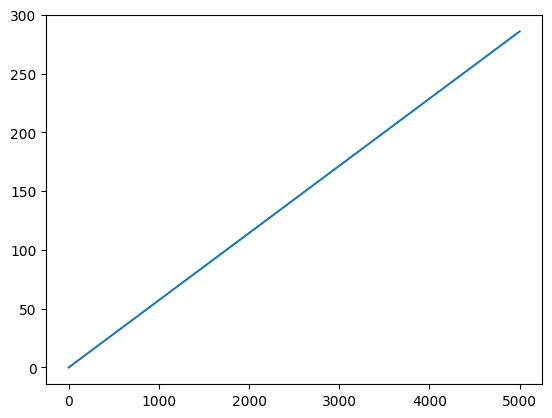

In [115]:
plt.plot(thetas[:,9,-1])

In [79]:
f = Kuramoto_2nd_mf
args = (omega,N,m,K)
result_ = RK4(f,np.r_[theta_init,np.zeros_like(theta_init)],t,args = args)

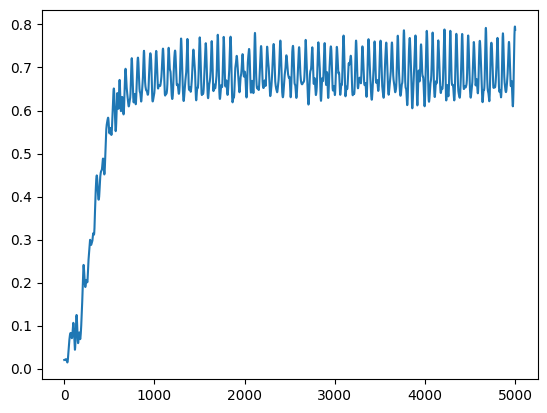

In [86]:
plt.plot(np.abs(np.sum(np.exp(result_[:,:N]*1j),axis=1)/N))

In [13]:
N_set = 20
theta_sets = (np.ones((N_set,1))*np.r_[theta_init,np.zeros_like(theta_init)])
omega_sets = (np.ones((N_set,1))*np.sort(omega))
K_set = np.arange(N_set).reshape(-1,1)

In [14]:
f = Kuramoto_2nd_mf_sets
omega_sets,N,m,K_set,N_set
args = (omega_sets,N,m,K_set,N_set)
thetas = RK4(f,theta_sets,t,args = args)

In [96]:
thetas[:,5,0].shape

(5000,)

In [99]:
abs(np.sum(np.exp(1j*thetas[2,5,:N]))/N)


0.01999916553513436

In [56]:
theta_sets.shape

(10, 1000)

In [64]:
np.arange(10).reshape(-1,1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [63]:
1/N*np.sum(np.exp(1j*theta_sets),axis=(1)).reshape((-1,1))

array([[1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j]])

In [8]:
def Sol_Kuramoto_mf2(K,N,m,t_array,p_theta = [], p_dtheta = [], p_omega = [],result_time = 0):
    theta, dtheta, omega  =  p_theta, p_dtheta,p_omega
    if m==0:
        function = Kuramoto_1st_mf_r
    else:
        function = Kuramoto_2nd_mf_r
    result,rs = RK4_r(function,np.r_[theta,dtheta],t_array,args=(omega,N,m,K),result_time=result_time)
    theta_s = result[:,:N]
    dtheta_s = result[:,N:2*N]
    if m == 0:
        dt = t_array[1]-t_array[0]
        dtheta_s = np.diff(theta_s/dt,axis=0)
    return theta_s,dtheta_s,rs

In [9]:
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

def get_order_parameter_sets(theta,N,M):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta),axis=1)
    r = np.abs(rpsi).reshape((-1,1))
    psi = np.angle(rpsi).reshape((-1,1))
    return r,psi

def Kuramoto_2nd_mf(Theta,t,omega,N,m,K):
    # print(f"Case m = {m}") 
    # theta,dtheta,r,psi = Theta[:N],Theta[N:2*N],Theta[-2],Theta[-1]
    theta,dtheta = Theta[:N],Theta[N:2*N]
    r,psi = get_order_parameter(theta,N)
    ddtheta = (1/m)*(-dtheta + omega + K*r*np.sin(psi - theta))
    return np.r_[dtheta,ddtheta]


In [41]:
np.sin([[1,2,3,4,5],[1,2,3,4,5]])

array([[ 0.84147098,  0.90929743,  0.14112001, -0.7568025 , -0.95892427],
       [ 0.84147098,  0.90929743,  0.14112001, -0.7568025 , -0.95892427]])

In [47]:
thetas.shape

(5000, 10, 1000)

In [10]:
def RK4_r_sets(f, y0, t, args=(),result_time = 0):
    n = len(t) - result_time
    y = np.zeros((n, *y0.shape))
    _,N,_,_,N_set = args
    rs = np.zeros((n+result_time,N_set,1))
    y[0] = y0
    h = t[1] - t[0]
    rs[0] = abs(1/N*np.sum(np.exp(1j*y0[:,:N]),axis=1)).reshape((-1,1))
    y_ = y0
    j = 0
    for i in range(result_time):
        k1,r = f(y_, t, *args)
        k2,_ = f(y_ + k1 * h / 2.0, t + h / 2.0, *args)
        k3,_ = f(y_ + k2 * h / 2.0, t + h / 2.0, *args)
        k4,_ = f(y_ + k3 * h, t + h, *args)
        y_ = y_ + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        rs[j+1] = r
        j+=1
    y[0] = y_
    for i in range(n - 1):
        k1,r = f(y[i], t[i], *args)
        k2,_ = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_ = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_ = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        rs[j+1] = r
        j+=1
    return y,rs

In [13]:
As = np.zeros((5,10,1))
As[0] = np.arange(10).reshape((-1,1))

In [14]:
np.arange(10).reshape((-1,1)).shape

(10, 1)

In [15]:
np.arange(10).reshape((-1,1)).shape

(10, 1)

In [16]:
np.arange(10).reshape((-1,1))

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [123]:
N_set = 10
theta_sets = (np.ones((N_set,1))*np.r_[theta_init,np.zeros_like(theta_init)])
omega_sets = (np.ones((N_set,1))*np.sort(omega))
K_set = np.arange(N_set).reshape(-1,1)
f = Kuramoto_2nd_mf_sets_r
args = (omega_sets,N,m,K_set,N_set)
Result,rs = RK4_r_sets(f,theta_sets,t,args = args)

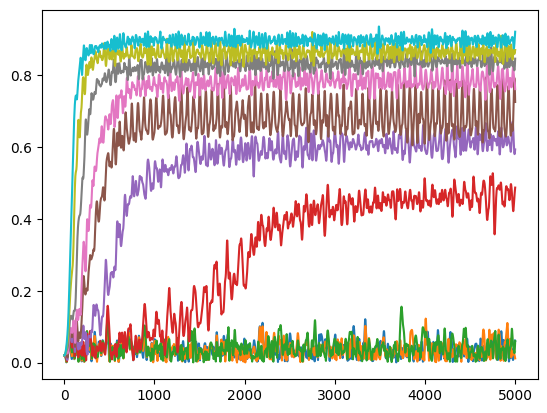

In [126]:
for i in range(N_set):
    plt.plot(rs[:,i])

In [16]:
f = Kuramoto_2nd_mf_sets
args = (omega_sets,N,m,K_set,N_set)
Result = RK4(f,theta_sets,t,args = args)

In [17]:
dthetas = Result[:,:,N:]
thetas = Result[:,:,:N]

In [131]:
thetas[:,0,:].shape

(5000, 500)

In [46]:
r_,psi_ = get_order_parameter_sets(thetas,N,N_set)

In [47]:
r_.shape

(25000000, 1)

In [202]:
rpsi = 1/N*np.sum(np.exp(1j*theta_sets[:,:N]),axis=1)
r = np.abs(rpsi).reshape(1,-1)
psi = np.angle(rpsi).reshape(1,-1)
psi.shape

(1, 20)

In [32]:
def Make_order_parameter(theta_s,N):
    rs = np.abs(np.sum(np.exp(1j*theta_s.T),axis=0))/N
    return rs

In [37]:
thetas.shape

(50000, 10, 500)

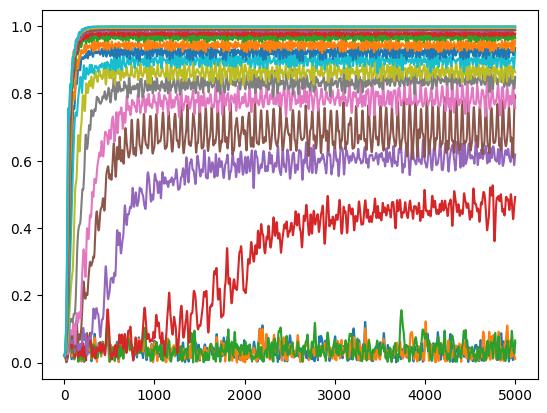

In [18]:
plt.plot((np.abs(np.sum(np.exp(1j*thetas),axis=2))/N))

In [50]:
K

5

In [51]:
f = Kuramoto_2nd_mf
args = (omega,N,m,K)
result = RK4(f,np.r_[theta_init,np.ones_like(theta_init)],t,args = args)
theta = result[:,:N]

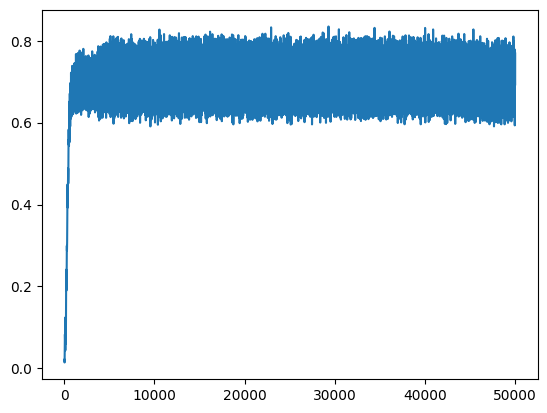

In [53]:
plt.plot((np.abs(np.sum(np.exp(1j*theta),axis=1))/N))


In [72]:
seed =10
N = 20
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
omega = np.sort(omega) 
K = 5
m = 5
t_end = 5000
dt =0.1
t = np.arange(0,t_end,dt)
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_init,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(600))*int(1/dt))
if m == 0:
        dtheta = np.c_[dtheta[0],dtheta.T].T

In [76]:
N_set = 10
theta_sets = (np.ones((N_set,1))*np.r_[theta_init,np.zeros_like(theta_init)])
omega_sets = (np.ones((N_set,1))*omega)
K_set = np.arange(10).reshape(-1,1)
m_set = np.arange(1,11).reshape(-1,1)



def Kuramoto_2nd_mf_sets_r(Theta_sets,t,omega_sets,N,m,K_set,N_set):
    theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
    r,psi = get_order_parameter_sets(theta,N,N_set)
    ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
    return np.c_[dtheta,ddtheta],r

In [78]:
y0 = np.zeros((10,*theta_sets.shape))
y0[0] = theta_sets
i = 0

In [93]:
theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
r,psi = get_order_parameter_sets(theta,N,N_set)
ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
theta_sets = np.c_[dtheta,ddtheta]
y0[i] = theta_sets
i+=1

## sol_Kuramoto_2nd_mf 2

In [42]:
def RK4_r_sets(f, y0, t, args=(),result_time = 0):
    n = len(t) - result_time
    y = np.zeros((n, *y0.shape))
    N_set = len(y0)
    _,N,_,_ = args
    rs = np.zeros((n+result_time,N_set,1))
    y[0] = y0
    h = t[1] - t[0]
    rs[0] = abs(1/N*np.sum(np.exp(1j*y0[:,:N]),axis=1)).reshape((-1,1))
    y_ = y0
    j = 0
    for i in range(result_time):
        k1,r = f(y_, t, *args)
        k2,_ = f(y_ + k1 * h / 2.0, t + h / 2.0, *args)
        k3,_ = f(y_ + k2 * h / 2.0, t + h / 2.0, *args)
        k4,_ = f(y_ + k3 * h, t + h, *args)
        y_ = y_ + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        rs[j+1] = r
        j+=1
    y[0] = y_
    for i in range(n - 1):
        k1,r = f(y[i], t[i], *args)
        k2,_ = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_ = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_ = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        rs[j+1] = r
        j+=1
    return y,rs

In [43]:
N_set = 10
theta_sets = (np.ones((N_set,1))*np.r_[theta_init,np.zeros_like(theta_init)])
omega_sets = (np.ones((N_set,1))*omega)
K_set = np.arange(10).reshape(-1,1)
m_set = np.arange(1,11).reshape(-1,1)

def get_order_parameter_sets(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta),axis=1)
    r = np.abs(rpsi).reshape((-1,1))
    psi = np.angle(rpsi).reshape((-1,1))
    return r,psi

def Kuramoto_2nd_mf_sets(theta_sets,t,omega_sets,N,m,K_set):
    theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
    r,psi = get_order_parameter_sets(theta,N)
    ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
    return np.c_[dtheta,ddtheta]

def Kuramoto_2nd_mf_sets_r(theta_sets,t,omega_sets,N,m,K_set):
    theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
    r,psi = get_order_parameter_sets(theta,N)
    ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
    return np.c_[dtheta,ddtheta],r

def Kuramoto_1st_mf_sets(theta_sets,t,omega,N,m,K_set):
    # print("Case m = 0")
    theta= theta_sets[:,:N]
    r,psi = get_order_parameter_sets(theta,N)
    dtheta = omega + K_set*r*np.sin(psi - theta)
    return np.c_[dtheta,np.zeros(N)]


def Kuramoto_1st_mf_sets_r(theta_sets,t,omega,N,m,K_set):
    # print("Case m = 0")
    theta= theta_sets[:,:N]
    r,psi = get_order_parameter_sets(theta,N)
    dtheta = omega + K_set*r*np.sin(psi - theta)
    return np.c_[dtheta,np.zeros(N)],r


In [44]:
def Sol_Kuramoto_mf2_sets(K_set,N,m,t_array,p_theta = [], p_dtheta = [], p_omega = [],result_time = 0):
    theta, dtheta, omega  =  p_theta, p_dtheta,p_omega
    if m==0:
        function = Kuramoto_1st_mf_sets_r
    else:
        function = Kuramoto_2nd_mf_sets_r
    result,rs = RK4_r_sets(function,np.c_[theta,dtheta],t_array,args=(omega,N,m,K_set),result_time=result_time)
    theta_s = result[:,:N]
    dtheta_s = result[:,N:2*N]
    if m == 0:
        dt = t_array[1]-t_array[0]
        dtheta_s = np.diff(theta_s/dt,axis=0)
    return theta_s,dtheta_s,rs

In [59]:
K_set = np.arange(0,10,0.1).reshape(-1,1)
m = 1
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(K_set)
theta_sets = (np.ones((N_set,1))*theta_init)
omega_sets = (np.ones((N_set,1))*omega)


omega = np.sort(omega) 

t_end = 500
dt =0.1
t = np.arange(0,t_end,dt)
theta, dtheta,rs = Sol_Kuramoto_mf2_sets(K_set,N=N,m=m,t_array=t,p_theta=theta_sets,p_dtheta= 0*omega_sets,p_omega=omega_sets)
if m == 0:
        dtheta = np.c_[dtheta[0],dtheta.T].T

In [62]:
K_lin = (K_set.reshape(-1))/(np.max(K_set)-np.min(K_set))
K_color = plt.cm.Blues(K_lin)

In [53]:
K_set.reshape(-1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

In [54]:
len(ln)

50000

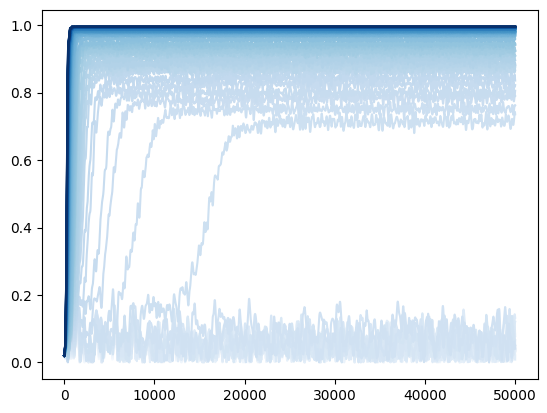

In [56]:
ln = plt.plot(rs.T[0].T)
for i,l in enumerate(ln):
    l.set_color(K_color[i])

ValueError: array([[0.96862745, 0.98431373, 1.        , 1.        ],
       [0.96247597, 0.98037678, 0.99803153, 1.        ],
       [0.95324875, 0.97447136, 0.99507882, 1.        ],
       [0.94709727, 0.97053441, 0.99311034, 1.        ],
       [0.93787005, 0.96462899, 0.99015763, 1.        ],
       [0.93171857, 0.96069204, 0.98818916, 1.        ],
       [0.92249135, 0.95478662, 0.98523645, 1.        ],
       [0.91326413, 0.9488812 , 0.98228374, 1.        ],
       [0.90711265, 0.94494425, 0.98031526, 1.        ],
       [0.89788543, 0.93903883, 0.97736255, 1.        ],
       [0.89173395, 0.93510188, 0.97539408, 1.        ],
       [0.88250673, 0.92919646, 0.97244137, 1.        ],
       [0.87327951, 0.92329104, 0.96948866, 1.        ],
       [0.86726644, 0.91935409, 0.96752018, 1.        ],
       [0.8584083 , 0.91344867, 0.96456747, 1.        ],
       [0.85250288, 0.90951173, 0.962599  , 1.        ],
       [0.84364475, 0.90360631, 0.95964629, 1.        ],
       [0.83773933, 0.89966936, 0.95767782, 1.        ],
       [0.8288812 , 0.89376394, 0.95472511, 1.        ],
       [0.82002307, 0.88785852, 0.9517724 , 1.        ],
       [0.81411765, 0.88392157, 0.94980392, 1.        ],
       [0.80525952, 0.87801615, 0.94685121, 1.        ],
       [0.79935409, 0.8740792 , 0.94488274, 1.        ],
       [0.79049596, 0.86817378, 0.94193003, 1.        ],
       [0.78163783, 0.86226836, 0.93897732, 1.        ],
       [0.77524029, 0.85830065, 0.9368243 , 1.        ],
       [0.76047674, 0.85202614, 0.93165705, 1.        ],
       [0.75063437, 0.84784314, 0.92821223, 1.        ],
       [0.73587082, 0.84156863, 0.92304498, 1.        ],
       [0.72602845, 0.83738562, 0.91960015, 1.        ],
       [0.7112649 , 0.83111111, 0.91443291, 1.        ],
       [0.69650135, 0.8248366 , 0.90926567, 1.        ],
       [0.68665898, 0.82065359, 0.90582084, 1.        ],
       [0.67189542, 0.81437908, 0.90065359, 1.        ],
       [0.66205306, 0.81019608, 0.89720877, 1.        ],
       [0.6472895 , 0.80392157, 0.89204152, 1.        ],
       [0.63252595, 0.79764706, 0.88687428, 1.        ],
       [0.62268358, 0.79346405, 0.88342945, 1.        ],
       [0.60470588, 0.78397539, 0.87913879, 1.        ],
       [0.59215686, 0.77708574, 0.87643214, 1.        ],
       [0.57333333, 0.76675125, 0.87237216, 1.        ],
       [0.5545098 , 0.75641676, 0.86831219, 1.        ],
       [0.54196078, 0.7495271 , 0.86560554, 1.        ],
       [0.52313725, 0.73919262, 0.86154556, 1.        ],
       [0.51058824, 0.73230296, 0.85883891, 1.        ],
       [0.49176471, 0.72196847, 0.85477893, 1.        ],
       [0.47921569, 0.71507882, 0.85207228, 1.        ],
       [0.46039216, 0.70474433, 0.8480123 , 1.        ],
       [0.44156863, 0.69440984, 0.84395233, 1.        ],
       [0.42901961, 0.68752018, 0.84124567, 1.        ],
       [0.41204152, 0.6771857 , 0.83626298, 1.        ],
       [0.40195309, 0.67029604, 0.83232603, 1.        ],
       [0.38682045, 0.65996155, 0.82642061, 1.        ],
       [0.37168781, 0.64962707, 0.82051519, 1.        ],
       [0.36159938, 0.64273741, 0.81657824, 1.        ],
       [0.34646674, 0.63240292, 0.81067282, 1.        ],
       [0.33637832, 0.62551326, 0.80673587, 1.        ],
       [0.32124567, 0.61517878, 0.80083045, 1.        ],
       [0.31115725, 0.60828912, 0.7968935 , 1.        ],
       [0.29602461, 0.59795463, 0.79098808, 1.        ],
       [0.28089196, 0.58762015, 0.78508266, 1.        ],
       [0.27080354, 0.58073049, 0.78114571, 1.        ],
       [0.25628604, 0.57001153, 0.7751634 , 1.        ],
       [0.24816609, 0.56189158, 0.77098039, 1.        ],
       [0.23598616, 0.54971165, 0.76470588, 1.        ],
       [0.22380623, 0.53753172, 0.75843137, 1.        ],
       [0.21568627, 0.52941176, 0.75424837, 1.        ],
       [0.20350634, 0.51723183, 0.74797386, 1.        ],
       [0.19538639, 0.50911188, 0.74379085, 1.        ],
       [0.18320646, 0.49693195, 0.73751634, 1.        ],
       [0.17102653, 0.48475202, 0.73124183, 1.        ],
       [0.16290657, 0.47663206, 0.72705882, 1.        ],
       [0.15072664, 0.46445213, 0.72078431, 1.        ],
       [0.14260669, 0.45633218, 0.71660131, 1.        ],
       [0.13042676, 0.44415225, 0.7103268 , 1.        ],
       [0.12402922, 0.4362476 , 0.70442138, 1.        ],
       [0.114802  , 0.42443676, 0.69519416, 1.        ],
       [0.10557478, 0.41262591, 0.68596694, 1.        ],
       [0.0994233 , 0.40475202, 0.67981546, 1.        ],
       [0.09019608, 0.39294118, 0.67058824, 1.        ],
       [0.0840446 , 0.38506728, 0.66443676, 1.        ],
       [0.07481738, 0.37325644, 0.65520953, 1.        ],
       [0.06559016, 0.3614456 , 0.64598231, 1.        ],
       [0.05943868, 0.3535717 , 0.63983083, 1.        ],
       [0.05021146, 0.34176086, 0.63060361, 1.        ],
       [0.04405998, 0.33388697, 0.62445213, 1.        ],
       [0.03483276, 0.32207612, 0.61522491, 1.        ],
       [0.03137255, 0.31409458, 0.60648981, 1.        ],
       [0.03137255, 0.30191465, 0.58840446, 1.        ],
       [0.03137255, 0.28973472, 0.57031911, 1.        ],
       [0.03137255, 0.28161476, 0.55826221, 1.        ],
       [0.03137255, 0.26943483, 0.54017686, 1.        ],
       [0.03137255, 0.26131488, 0.52811995, 1.        ],
       [0.03137255, 0.24913495, 0.5100346 , 1.        ],
       [0.03137255, 0.23695502, 0.49194925, 1.        ],
       [0.03137255, 0.22883506, 0.47989235, 1.        ],
       [0.03137255, 0.21665513, 0.461807  , 1.        ],
       [0.03137255, 0.20853518, 0.4497501 , 1.        ],
       [0.03137255, 0.19635525, 0.43166474, 1.        ],
       [0.03137255, 0.18823529, 0.41960784, 1.        ]]) is not a valid value for color

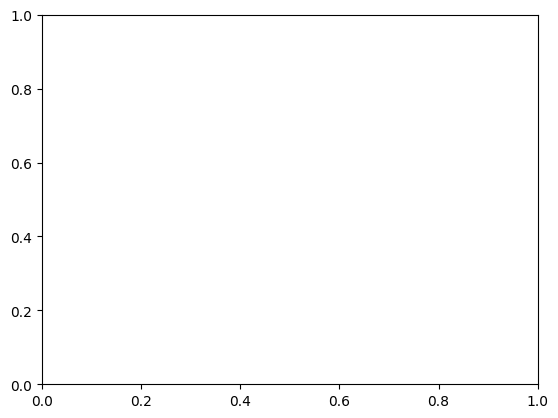

In [63]:
plt.plot(rs[:,:,0]);